In [1]:
# import libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import helper_functions1 as hf

In [2]:
# load hourly dataset
bikes_df = pd.read_csv('bike_sharing_dataset/hour.csv')
# initialize helper_function dataclean object
dataclean = hf.DataCleaning()

In [3]:
# explore
bikes_df.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


#### feature information   

* instant: record index 
* dteday: datetime 
* season of the year (1: spring, 2: summer, 3: fall, 4: winter)
* yr: (0:2011, 1: 2012) 
* mnth: month(1 to 12)
* hr: hour (0 to 23) 
* holiday: (1 is holiday, 0 is not) 
* weekday: day of the week 
* working day: neither holiday or weekend is 1 otherwise 0
* weathersit : 
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
* atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered

In [ ]:
# bikes_df.info()

#### data type summary:

* zero non null objects 
* dteday: convert to datetime object and set as index 
* convert season, yr, mnth, holiday, weekday, workingday, weathersit to categorical value 

In [4]:
# don't need instant column 
bikes_df.drop(columns=['instant'], inplace=True)
bikes_df.head(2)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40


In [5]:
# convert dteday as datetime object 
bikes_df['dteday'] = pd.to_datetime(bikes_df.dteday)
# set dteday as index 
bikes_df.set_index('dteday',inplace=True)

In [6]:
# hour will convert to string and change into categorical
bikes_df['hr'] = bikes_df.hr.astype('str').astype('category')

In [7]:
# convert numerical columns to categorical columns 
# columns of interest 
cat_cols = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
col_dict_maps = [{1:'spring',2:'summer',3:'fall',4:'winter'},
                {0:'2011', 1: '2012'}, 
                {1:'jan', 2:'feb',3:'mar',4:'apr',5:'may', 6:'jun',7:'jul',8:'aug',
                 9:'sep',10:'oct',11:'nov',12:'dec'}, {1:'holiday',0:'not_holiday'},
                {0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'},
                {1:'working',0:'not_working'},
                {1:'clear',2:'mist',3:'light_rain_snow',4:'heavy_rain_snow'}]
for col, dict_map in zip(cat_cols,col_dict_maps):
    bikes_df[col] = dataclean.change_colvalue(bikes_df,col, dict_map)   

In [8]:
# convert them to categorical value
bikes_df[cat_cols] = bikes_df[cat_cols].astype('category')

In [9]:
# one hot encoder 
bikes_df = pd.get_dummies(bikes_df,drop_first=True )

In [10]:
props_users = dataclean.convert_to_prop(bikes_df, ['casual','registered','cnt'])
props_users.describe()
# if casual user is more than average, we will say more casual users than usual 

,casual,registered
count,17379.000000,17379.000000
mean,0.172143,0.827857
std,0.136557,0.136557
min,0.000000,0.000000
25%,0.063492,0.746269
50%,0.146893,0.853107
75%,0.253731,0.936508
max,1.000000,1.000000


In [11]:
# create a binary outcome col for logistic regression 
# cut off is at 0.2 then above average casual user 
# 0 is no and 1 is yes 
bikes_df['above_avg_casual'] = np.where(props_users.casual > 0.2, 1,0)
# binary target 
bikes_df.above_avg_casual.value_counts()
# an imbalance in class so we will play with sampling when perform logistic regression 

0    11121
1     6258
Name: above_avg_casual, dtype: int64

In [12]:
# drop casual and registered colnames 
bikes_df.drop(columns=['casual','registered'], inplace = True)

In [13]:
bikes_df[['temp','atemp','cnt','above_avg_casual']].corr()
# we will pick temp as highly correlated 

,temp,atemp,cnt,above_avg_casual
temp,1.000000,0.987672,0.404772,0.351232
atemp,0.987672,1.000000,0.400929,0.350031
cnt,0.404772,0.400929,1.000000,0.070084
above_avg_casual,0.351232,0.350031,0.070084,1.000000


In [14]:
bikes_df.drop(columns=['atemp'], inplace = True)

In [15]:
# look seasonality or month for features 
bikes_df[['cnt','season_spring', 'season_winter', 'season_summer','above_avg_casual']].corr()

,cnt,season_spring,season_winter,season_summer,above_avg_casual
cnt,1.000000,-0.245456,0.029421,0.060692,0.070084
season_spring,-0.245456,1.000000,-0.322401,-0.331312,-0.201344
season_winter,0.029421,-0.322401,1.000000,-0.330795,-0.119506
season_summer,0.060692,-0.331312,-0.330795,1.000000,0.135363
above_avg_casual,0.070084,-0.201344,-0.119506,0.135363,1.000000


In [16]:
bikes_df[['cnt','mnth_dec','mnth_aug', 'mnth_feb', 
          'mnth_jan', 'mnth_jul', 'mnth_jun', 'mnth_mar','mnth_may', 'mnth_nov', 
          'mnth_oct', 'mnth_sep','above_avg_casual']].corr()

,cnt,mnth_dec,mnth_aug,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sep,above_avg_casual
cnt,1.000000,-0.079415,0.081657,-0.122113,-0.156834,0.071459,0.084600,-0.057131,0.056422,-0.020074,0.054406,0.084931,0.070084
mnth_dec,-0.079415,1.000000,-0.093019,-0.088321,-0.091424,-0.093466,-0.091807,-0.092950,-0.093466,-0.091703,-0.092189,-0.091703,-0.138164
mnth_aug,0.081657,-0.093019,1.000000,-0.088061,-0.091155,-0.093190,-0.091536,-0.092675,-0.093190,-0.091432,-0.091917,-0.091432,0.087257
mnth_feb,-0.122113,-0.088321,-0.088061,1.000000,-0.086552,-0.088484,-0.086914,-0.087995,-0.088484,-0.086815,-0.087276,-0.086815,-0.133360
mnth_jan,-0.156834,-0.091424,-0.091155,-0.086552,1.000000,-0.091593,-0.089968,-0.091087,-0.091593,-0.089865,-0.090342,-0.089865,-0.156463
mnth_jul,0.071459,-0.093466,-0.093190,-0.088484,-0.091593,1.000000,-0.091976,-0.093121,-0.093638,-0.091872,-0.092359,-0.091872,0.133743
mnth_jun,0.084600,-0.091807,-0.091536,-0.086914,-0.089968,-0.091976,1.000000,-0.091469,-0.091976,-0.090242,-0.090720,-0.090242,0.082388
mnth_mar,-0.057131,-0.092950,-0.092675,-0.087995,-0.091087,-0.093121,-0.091469,1.000000,-0.093121,-0.091365,-0.091849,-0.091365,0.004126
mnth_may,0.056422,-0.093466,-0.093190,-0.088484,-0.091593,-0.093638,-0.091976,-0.093121,1.000000,-0.091872,-0.092359,-0.091872,0.094758
mnth_nov,-0.020074,-0.091703,-0.091432,-0.086815,-0.089865,-0.091872,-0.090242,-0.091365,-0.091872,1.000000,-0.090617,-0.090139,-0.072446


In [17]:
# choose seasonality or month as higher correlation and less cols
bikes_df.drop(columns=['mnth_dec','mnth_aug', 'mnth_feb', 
          'mnth_jan', 'mnth_jul', 'mnth_jun', 'mnth_mar','mnth_may', 'mnth_nov', 
          'mnth_oct', 'mnth_sep'], inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a29cb00>,
      dtype=object)

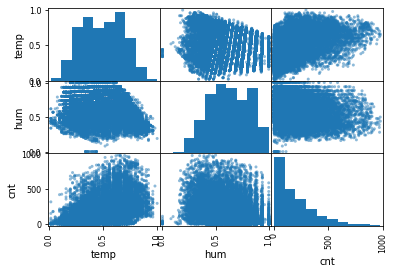

In [18]:
# take scatter_matrix plots of all numerical values to consider for transformation 
pd.plotting.scatter_matrix(bikes_df[['temp','hum','cnt']])
# we will pick temp as highly correlated 

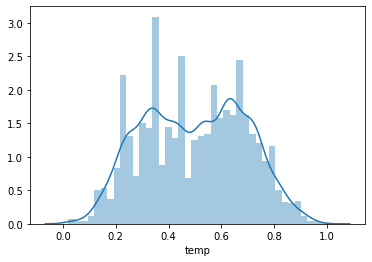

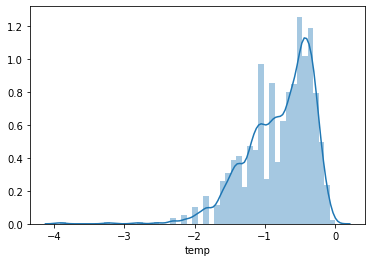

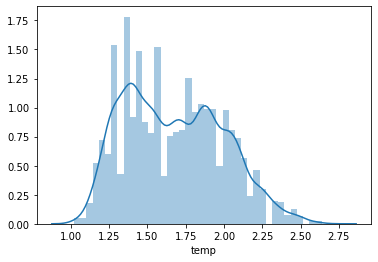

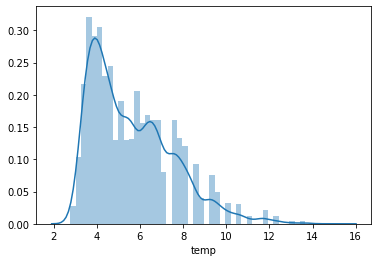

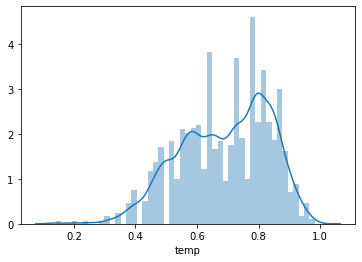

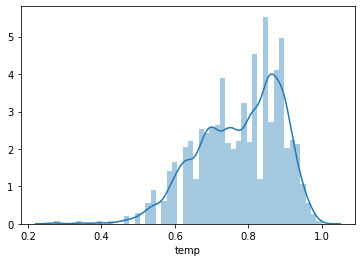

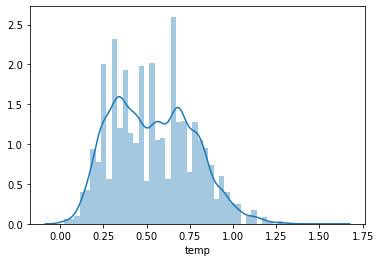

In [19]:
# check various transformations of temp column and pick the best transformation
# for normal distribution 
sns.distplot(bikes_df.temp)
plt.show()
sns.distplot(np.log(bikes_df.temp))
plt.show()
sns.distplot(np.exp(bikes_df.temp))
plt.show()
sns.distplot(np.exp(np.exp(bikes_df.temp)))
plt.show()
sns.distplot(np.sqrt(bikes_df.temp))
plt.show()
sns.distplot(np.power(bikes_df.temp,1/3))
plt.show()
sns.distplot(np.arcsin(bikes_df.temp))
# log scale 

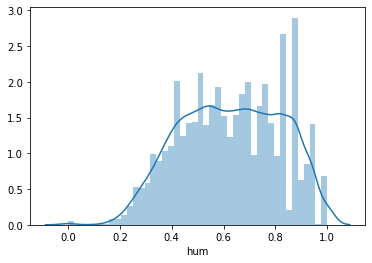

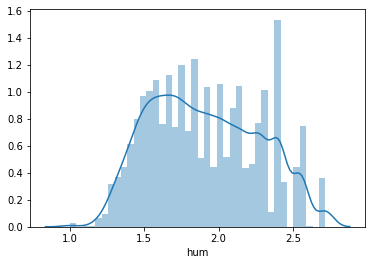

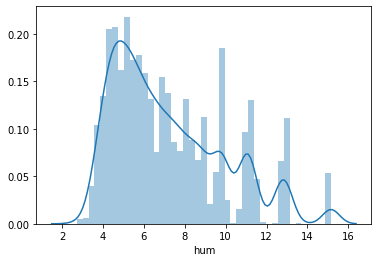

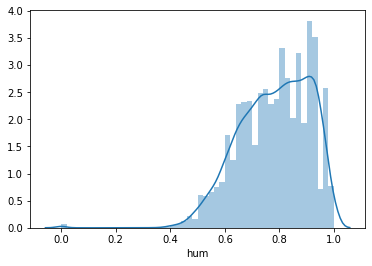

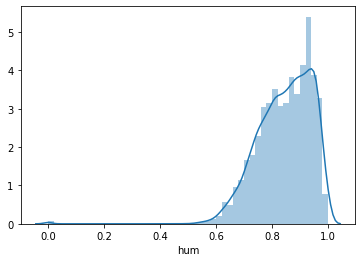

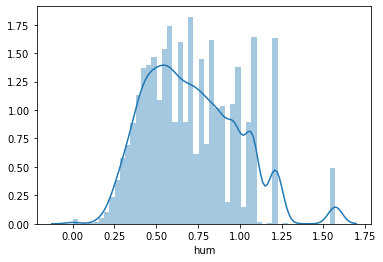

In [20]:
# check various transformations of hum column and pick the best transformation
# for normal distribution 
sns.distplot(bikes_df.hum)
plt.show()
# sns.distplot(np.log(bikes_df.hum))
# plt.show()
sns.distplot(np.exp(bikes_df.hum))
plt.show()
sns.distplot(np.exp(np.exp(bikes_df.hum)))
plt.show()
sns.distplot(np.sqrt(bikes_df.hum))
plt.show()
sns.distplot(np.power(bikes_df.hum,1/3))
plt.show()
sns.distplot(np.arcsin(bikes_df.hum))
# cubic root 

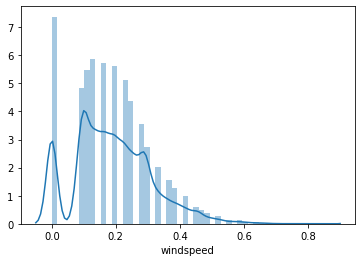

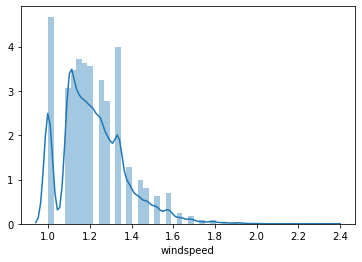

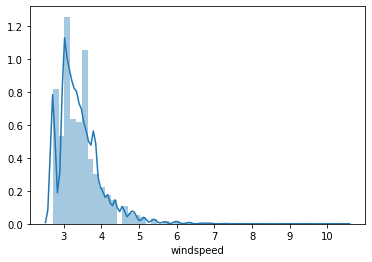

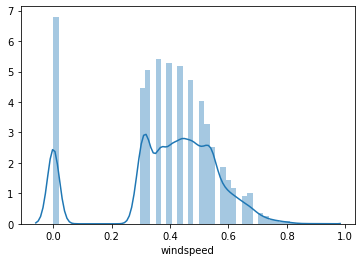

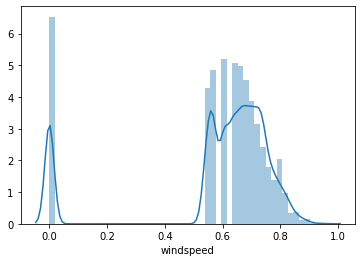

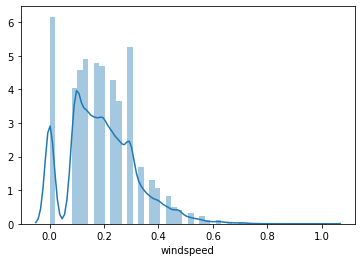

In [21]:
# check various transformations of windspeed column and pick the best transformation
# for normal distribution 
sns.distplot(bikes_df.windspeed)
plt.show()
# sns.distplot(np.log(bikes_df.windspeed))
# plt.show()
sns.distplot(np.exp(bikes_df.windspeed))
plt.show()
sns.distplot(np.exp(np.exp(bikes_df.windspeed)))
plt.show()
sns.distplot(np.sqrt(bikes_df.windspeed))
plt.show()
sns.distplot(np.power(bikes_df.windspeed,1/4))
plt.show()
sns.distplot(np.arcsin(bikes_df.windspeed))
# default although 0 is an outlier 

In [22]:
# final transformations 
# logscale target cnt and temp 
bikes_df['cnt'] = np.log(bikes_df.cnt)
bikes_df['temp'] = np.log(bikes_df.temp)
# cubic root hum
bikes_df['hum'] = np.power(bikes_df.hum,1/3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12af1d6d8>,
      dtype=object)

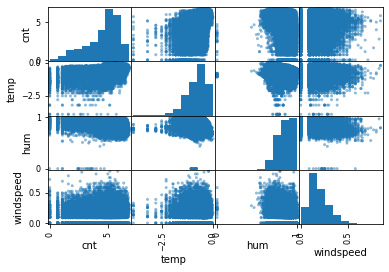

In [23]:
pd.plotting.scatter_matrix(bikes_df[['cnt','temp','hum','windspeed']])

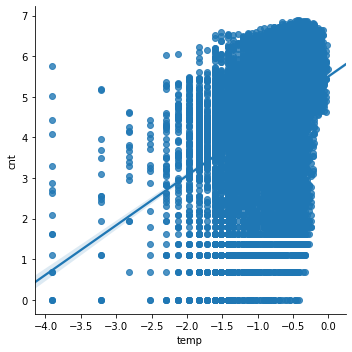

In [24]:
sns.lmplot('temp', 'cnt', data = bikes_df)

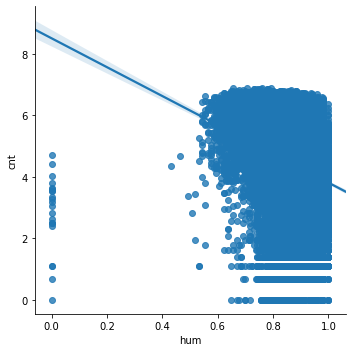

In [25]:
sns.lmplot('hum', 'cnt', data = bikes_df)

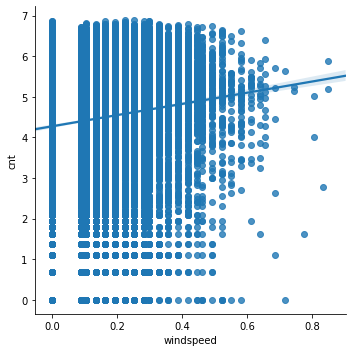

In [26]:
sns.lmplot('windspeed', 'cnt', data = bikes_df)

In [27]:
# bikes_df for regression
bikes_df.drop(columns=['above_avg_casual']).to_pickle('cleaned_data/bikes_regression.pkl')
# bikes_df for logistic regression
bikes_df.drop(columns = ['cnt']).to_pickle('cleaned_data/bikes_logistic.pkl')